In [6]:
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
K=5
CATEGORIES = ['Electron','Muon','Tau','Quark']

In [33]:
pickle_in = open("XLEP.pickle","rb")
X0 = pickle.load(pickle_in)

pickle_in = open("yLEP.pickle","rb")
z0 = pickle.load(pickle_in)

X = np.array(X0)

y = np.array(z0)

# K-fold cross-validation:

In [34]:


df_x = pd.DataFrame({'X_data': [X[i] for i in range(len(X))] })
df_y = pd.DataFrame({'y_data': y })

df_final = pd.concat([df_y,df_x], axis=1)
df_final.head()


,y_data,X_data
0,0,"[0.264923095703125, -0.08237313479185104, -0.0..."
1,1,"[0.9543304443359375, 0.46060577034950256, 0.46..."
2,0,"[0.1748199462890625, -0.9757654666900635, -0.9..."
3,1,"[0.0, -0.8283840417861938, -0.8284099102020264..."
4,0,"[4.1381988525390625, 0.46575456857681274, 0.50..."


# training K-times with shufled data and savind the predictions of each time

In [35]:

interval = int(len(X)/K)
X_u = df_final['X_data']
y_u = df_final['y_data']
    
Xinterval = []
yinterval = []
for i in range(K):
    xsub_set = []
    ysub_set = []
    xsub_set = np.array([X_u[j] for j in range(i*interval,(i+1)*interval)])
    ysub_set = np.array([y_u[j] for j in range(i*interval,(i+1)*interval)])
    Xinterval.append(xsub_set)
    yinterval.append(ysub_set)


In [36]:
cointerval = (K-1)*interval
interval + cointerval

400000

In [43]:
coXinterval = []
coyinterval = []
for i in range(K):
    aaa=[]
    bbb=[]
    for j in range(K):
        if j == i:
            pass
        else:
            aaa.append(Xinterval[j])
            bbb.append(yinterval[j])
    coXinterval.append(aaa)
    coyinterval.append(bbb)

for k in range(K):
    coXinterval[k] = np.reshape(coXinterval[k],(cointerval,14))
    coyinterval[k] = np.reshape(coyinterval[k],(cointerval,1))
len(yinterval[2]),len(coyinterval[2])



(80000, 320000)

In [44]:

import tensorflow as tf
from tensorflow.keras.models import Sequential  # for a sequential model 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
#import time

dense_layer = 1
layer_size = 128
drop_layer = 0.3

pred_cross = {}
score = []
#'fst-LEP-0.1-dr-128-l-1-de.model'
scaler = StandardScaler()

for i in range(K):
    
    X_test = Xinterval[i]
    X_train = coXinterval[i]
    
    
    y_test = yinterval[i]
    y_train = coyinterval[i]
           
    # Fit only to the training data
    scaler.fit(X_train)

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

#    
#    NAMEk = "{}-fold-{}-dr-{}-l-{}-de-{}".format(K,drop_layer, layer_size, dense_layer, int(time.time()))
#    tensorboard = TensorBoard(log_dir = 'log/{}'.format(NAMEk))

    model = Sequential()
    model.add(Dense(layer_size,input_shape = (int(14),)))
    model.add(Activation('relu'))
    model.add(Dropout(drop_layer))                                       # dropout 10% of the neurons
    #           model.add(MaxPooling2D(pool_size=(2, 2)))

    #           model.add(Flatten())
    for l in range(dense_layer):
        model.add(Dense(layer_size))
        model.add(Activation('relu'))
        model.add(Dropout(drop_layer))# dropout 10% of the neurons

    model.add(Dense(4))
    model.add(Activation('softmax'))

    #qual otimizador?
    model.compile(loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

    LEP_model = model.fit(X_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.3)#,
#              callbacks=[tensorboard])

    pred_cross[str(i)+'pred'] = model.predict(X_test)
    score.append(model.evaluate(X_test,y_test))
    

Train on 224000 samples, validate on 96000 samples
Epoch 1/10
224000/224000 [==============================] - 20s 88us/step - loss: 0.1112 - acc: 0.9608 - val_loss: 0.0566 - val_acc: 0.9788
Epoch 2/10
224000/224000 [==============================] - 18s 81us/step - loss: 0.0612 - acc: 0.9780 - val_loss: 0.0464 - val_acc: 0.9828
Epoch 3/10
224000/224000 [==============================] - 19s 83us/step - loss: 0.0539 - acc: 0.9804 - val_loss: 0.0415 - val_acc: 0.9839
Epoch 4/10
224000/224000 [==============================] - 18s 82us/step - loss: 0.0507 - acc: 0.9814 - val_loss: 0.0395 - val_acc: 0.9854
Epoch 5/10
224000/224000 [==============================] - 17s 76us/step - loss: 0.0493 - acc: 0.9820 - val_loss: 0.0408 - val_acc: 0.9854
Epoch 6/10
224000/224000 [==============================] - 15s 68us/step - loss: 0.0483 - acc: 0.9823 - val_loss: 0.0366 - val_acc: 0.9865
Epoch 7/10
224000/224000 [==============================] - 15s 69us/step - loss: 0.0471 - acc: 0.9825 - val_

In [45]:
loss = [score[i][0] for i in range(K)]
acc = [score[i][1] for i in range(K)]
score
print('acc for K={}: {}+-{}'.format(K,np.average(acc),np.std(acc)))

acc for K=5: 0.9855499999999999+-0.0005420447398508781


In [46]:
for i in range(K):
    pred_cross[i] = pd.DataFrame(pred_cross[str(i)+'pred'])

pred_cross['2pred']

array([[2.2485303e-06, 1.6784212e-04, 9.9975878e-01, 7.1142880e-05],
       [1.9651507e-27, 6.2029181e-22, 1.8989266e-07, 9.9999976e-01],
       [1.7280138e-08, 9.9866068e-01, 1.3392995e-03, 2.9823321e-11],
       ...,
       [5.7212600e-22, 8.6932970e-19, 5.2090604e-06, 9.9999475e-01],
       [1.0197239e-10, 9.9990273e-01, 9.7308504e-05, 4.1542975e-14],
       [9.9999917e-01, 1.4263951e-13, 8.2667162e-07, 1.2711623e-31]],
      dtype=float32)

In [47]:
y_pred = []
y_prob=[]
for i in range(K):
    y_pred.append([np.argmax(pred_cross[str(i)+'pred'][j]) for j in range(len(y_test))]) #  10 x 40000 array
    y_prob.append([np.max(pred_cross[str(i)+'pred'][j]) for j in range(len(y_test))])    # 10 x 40000  array



In [48]:
y_prob[4][39999]

0.9998092

In [49]:
pd_y_test = pd.DataFrame({'y_test':y_test})
pd_y_prob = {}
pd_y_pred = {}
for i in range(K):
    pd_y_prob['y_prob'+str(i)] = y_prob[i]
    pd_y_pred['y_pred'+str(i)] = y_pred[i]
    
pd_y_prob = pd.DataFrame(pd_y_prob)
pd_y_pred = pd.DataFrame(pd_y_pred)

df_final = pd.concat([pd_y_test,pd_y_pred,pd_y_prob], axis=1)


In [50]:
df_final.head()

,y_test,y_pred0,y_pred1,y_pred2,y_pred3,y_pred4,y_prob0,y_prob1,y_prob2,y_prob3,y_prob4
0,3,0,2,2,1,3,0.999608,0.994854,0.999759,0.999843,1.000000
1,2,2,3,3,2,2,0.806677,0.999936,1.000000,0.999983,0.999139
2,0,0,0,1,2,0,1.000000,1.000000,0.998661,0.992724,0.999976
3,2,1,3,2,1,2,0.999910,1.000000,0.993960,0.999874,0.999501
4,3,0,0,1,3,3,0.999999,0.999904,0.999294,1.000000,1.000000


# Saving the DATA :

In [52]:
#saving df_final

#import pickle

#pickle_out = open("5-fold-data-LEP.pickle","wb")
#pickle.dump(df_final, pickle_out)
#pickle_out.close()

In [150]:
#load

import pickle


pickle_in = open("5-fold-data-LEP.pickle","rb")
df_fin = pickle.load(pickle_in)
df_fin.head(10)

,y_test,y_pred0,y_pred1,y_pred2,y_pred3,y_pred4,y_prob0,y_prob1,y_prob2,y_prob3,y_prob4
0,3,0,2,2,1,3,0.999608,0.994854,0.999759,0.999843,1.000000
1,2,2,3,3,2,2,0.806677,0.999936,1.000000,0.999983,0.999139
2,0,0,0,1,2,0,1.000000,1.000000,0.998661,0.992724,0.999976
3,2,1,3,2,1,2,0.999910,1.000000,0.993960,0.999874,0.999501
4,3,0,0,1,3,3,0.999999,0.999904,0.999294,1.000000,1.000000
5,1,0,0,2,0,1,0.999979,1.000000,0.999328,0.999999,0.999926
6,2,1,1,2,0,2,0.999901,0.999627,0.628046,0.999951,0.999887
7,1,2,3,0,3,1,0.999940,0.999674,0.999999,1.000000,0.999851
8,2,1,2,3,2,2,0.999917,0.999884,0.762106,0.999968,0.999420
9,0,0,0,2,3,0,0.999072,0.999982,0.999856,1.000000,1.000000


In [151]:

pd_y_test = pd.DataFrame( {'y_test':df_fin['y_test']})
y_pred = [df_fin['y_pred'+str(i)] for i in range(K)]
y_prob = [df_fin['y_prob'+str(i)] for i in range(K)]

In [152]:
df_final00 = pd.concat([pd_y_test,pd.DataFrame({'y_pred':y_pred[0]}),pd.DataFrame({'y_prob':y_prob[0]})], axis=1)
df_final11 = pd.concat([pd_y_test,pd.DataFrame({'y_pred':y_pred[1]}),pd.DataFrame({'y_prob':y_prob[1]})], axis=1)
df_final22 = pd.concat([pd_y_test,pd.DataFrame({'y_pred':y_pred[2]}),pd.DataFrame({'y_prob':y_prob[2]})], axis=1)
df_final33 = pd.concat([pd_y_test,pd.DataFrame({'y_pred':y_pred[3]}),pd.DataFrame({'y_prob':y_prob[3]})], axis=1)
df_final44 = pd.concat([pd_y_test,pd.DataFrame({'y_pred':y_pred[4]}),pd.DataFrame({'y_prob':y_prob[4]})], axis=1)
df_list =[df_final00,df_final11,df_final22,df_final33,df_final44] #40000 test events


In [153]:
df_list[4].head()

,y_test,y_pred,y_prob
0,3,3,1.000000
1,2,2,0.999139
2,0,0,0.999976
3,2,2,0.999501
4,3,3,1.000000


In [154]:
TPR = []
FPR = []

TPR_final = []
FPR_final = []
for i in range(K): 
    df_list_0 = pd.DataFrame({})
    df_list_1 = pd.DataFrame({})
    df_list_2 = pd.DataFrame({})
    df_list_3 = pd.DataFrame({})
    
#    df_list_0 = df_list[i][df_list[i]['y_test'] == 0]
#    df_list_1 = df_list[i][df_list[i]['y_test'] == 1]
#    df_list_2 = df_list[i][df_list[i]['y_test'] == 2]
#    df_list_3 = df_list[i][df_list[i]['y_test'] == 3]
    
    shift = 500
    sh = 0
    threshold = [sh + (1-sh)*((i+1)/shift) for i in range(shift)]
    count_0_ROC = []
    count_1_ROC = []
    count_2_ROC = []
    count_3_ROC = []

    countf_0_ROC = []
    countf_1_ROC = []
    countf_2_ROC = []
    countf_3_ROC = []

    for thr in threshold:
        
        #count the True positive of class-0,1, 2 and 3:
        n0tp_ROC = df_list[i][(df_list[i]['y_test'] == 0) & (df_list[i].y_pred == 0) & (df_list[i].y_prob > thr)].count()        
        n1tp_ROC = df_list[i][(df_list[i]['y_test'] == 1) & (df_list[i].y_pred == 1) & (df_list[i].y_prob > thr)].count()        
        n2tp_ROC = df_list[i][(df_list[i]['y_test'] == 2) & (df_list[i].y_pred == 2) & (df_list[i].y_prob > thr)].count()
        n3tp_ROC = df_list[i][(df_list[i]['y_test'] == 3) & (df_list[i].y_pred == 3) & (df_list[i].y_prob > thr)].count()

        #count the False negative of class-0,1, 2 and 3:
        n0fn_ROC = df_list[i][(df_list[i]['y_test'] == 0) & (df_list[i].y_pred == 0) & (df_list[i].y_prob < thr)].count()

        n1fn_ROC = df_list[i][(df_list[i]['y_test'] == 1) & (df_list[i].y_pred == 1) & (df_list[i].y_prob < thr)].count() 
        
        n2fn_ROC = df_list[i][(df_list[i]['y_test'] == 2) & (df_list[i].y_pred == 2) & (df_list[i].y_prob < thr)].count() 
        
        n3fn_ROC = df_list[i][(df_list[i]['y_test'] == 3) & (df_list[i].y_pred == 3) & (df_list[i].y_prob < thr)].count()             
        

        # false positive of class-0,1, 2 and 3:
        n0fp_ROC = df_list[i][(df_list[i]['y_test'] != 0) & (df_list[i].y_pred == 0) & (df_list[i].y_prob > thr)].count()
        n1fp_ROC = df_list[i][(df_list[i]['y_test'] != 1) & (df_list[i].y_pred == 1) & (df_list[i].y_prob > thr)].count()  
        n2fp_ROC = df_list[i][(df_list[i]['y_test'] != 2) & (df_list[i].y_pred == 2) & (df_list[i].y_prob > thr)].count()  
        n3fp_ROC = df_list[i][(df_list[i]['y_test'] != 3) & (df_list[i].y_pred == 3) & (df_list[i].y_prob > thr)].count()  

       # true negative of class-0,1, 2 and 3:
        n0tn_ROC = df_list[i][(df_list[i]['y_test'] != 0) & (df_list[i].y_pred != 0) & (df_list[i].y_prob < thr)].count()
        n1tn_ROC = df_list[i][(df_list[i]['y_test'] != 1) & (df_list[i].y_pred != 1) & (df_list[i].y_prob < thr)].count() 
        n2tn_ROC = df_list[i][(df_list[i]['y_test'] != 2) & (df_list[i].y_pred != 2) & (df_list[i].y_prob < thr)].count() 
        n3tn_ROC = df_list[i][(df_list[i]['y_test'] != 3) & (df_list[i].y_pred != 3) & (df_list[i].y_prob < thr)].count() 


    #    #creating a list with the results for TPR and FPR:
        
        count_0_ROC.append(n0tp_ROC[0]/(n0tp_ROC[0] + n0fn_ROC[0] ))   #TPR = TP/(TP  + FN)
        count_1_ROC.append(n1tp_ROC[0]/(n1tp_ROC[0] + n1fn_ROC[0] )) 
        count_2_ROC.append(n2tp_ROC[0]/(n2tp_ROC[0] + n2fn_ROC[0] ))     
        count_3_ROC.append(n3tp_ROC[0]/(n3tp_ROC[0] + n3fn_ROC[0] ))     

        countf_0_ROC.append( n0fp_ROC[0]/(n0tn_ROC[0]+ n0fp_ROC[0] ))     #FPR = FP / (FP + TN)  
        countf_1_ROC.append( n1fp_ROC[0]/(n1tn_ROC[0]+ n1fp_ROC[0] ))
        countf_2_ROC.append( n2fp_ROC[0]/(n2tn_ROC[0] + n2fp_ROC[0] ))
        countf_3_ROC.append(n3fp_ROC[0]/(n3tn_ROC[0]+ n3fp_ROC[0] ))

    
    
        TPR =[count_0_ROC,count_1_ROC,count_2_ROC,count_3_ROC]
        FPR = [countf_0_ROC,countf_1_ROC,countf_2_ROC,countf_3_ROC]
        
    TPR_final.append(TPR)
    FPR_final.append(FPR)

In [155]:
#np.average([TPR_final[i][3][19]for i in range(K)] )  # K x class x thr

In [156]:
TPR_ave = []
FPR_ave = []
for i in range(len(CATEGORIES)):
    ccc=[]
    ddd=[]
    for j in range(shift):
        ccc.append(np.average([TPR_final[k][i][j] for k in range(K)]))
        ddd.append(np.average([FPR_final[k][i][j] for k in range(K)]))
    TPR_ave.append(ccc)
    FPR_ave.append(ddd)

In [157]:
TPR_std = []
FPR_std = []
for i in range(len(CATEGORIES)):
    ccc=[]
    ddd=[]
    for j in range(shift):
        ccc.append(np.std([TPR_final[k][i][j] for k in range(K)]))
        ddd.append(np.std([FPR_final[k][i][j] for k in range(K)]))
    TPR_std.append(ccc)
    FPR_std.append(ddd)

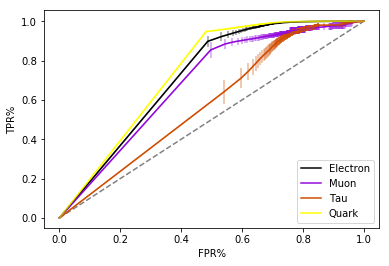

In [162]:
x_lin = np.linspace(0., 1, shift)
number = len(CATEGORIES)
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

fig, ax = plt.subplots()
ax.plot(x_lin, x_lin , '--',color = 'gray')
for j , color in enumerate(colors, start=0):
    plt.plot(FPR_ave[j],TPR_ave[j],color = color,label= CATEGORIES[j])#xerr=FPR_std[j],
    plt.errorbar(FPR_ave[j],TPR_ave[j],yerr=TPR_std[j],color = color,alpha=0.4)
    plt.legend(loc='lower right',fontsize=10)
plt.xlabel('FPR%')
plt.ylabel('TPR%')

In [163]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit


def func(x, b ):

    return(np.tanh(b*x))

# data 
x_0 = np.array(FPR_ave[0])
x_1 = np.array(FPR_ave[1])
x_2 = np.array(FPR_ave[2])
x_3 = np.array(FPR_ave[3])

y_0 = np.array(TPR_ave[0])
y_1 = np.array(TPR_ave[1])
y_2 = np.array(TPR_ave[2])
y_3 = np.array(TPR_ave[3])

# curve fit [with only y-error]
popt_0, pcov_0 = curve_fit(func, x_0, y_0) # ,sigma=1./(noise_0*noise_0)
perr_0 = np.sqrt(np.diag(pcov_0))
popt_1, pcov_1 = curve_fit(func, x_1, y_1) # ,sigma=1./(noise_1*noise_1)
perr_1 = np.sqrt(np.diag(pcov_1))
popt_2, pcov_2 = curve_fit(func, x_2, y_2) # ,sigma=1./(noise_2*noise_2)
perr_2 = np.sqrt(np.diag(pcov_2))
popt_3, pcov_3 = curve_fit(func, x_3, y_3) # ,sigma=1./(noise_2*noise_2)
perr_3 = np.sqrt(np.diag(pcov_3))


fit_0 = func(x_0, popt_0)
fit_1 = func(x_1, popt_1)
fit_2 = func(x_2, popt_2)
fit_3 = func(x_3, popt_3)
from scipy import integrate
#f0=func(x,popt_0)
AUC_0 = integrate.quad(func, 0, 1,args=popt_0)
AUC_1 = integrate.quad(func, 0, 1,args=popt_1)
AUC_2 = integrate.quad(func, 0, 1,args=popt_2)
AUC_3 = integrate.quad(func, 0, 1,args=popt_3)
print('AUC parameter :',str(CATEGORIES[0])+ ':'+ str(AUC_0[0]) + '+-' + str(AUC_0[1]) )
print('AUC parameter :',str(CATEGORIES[1])+ ':' +str(AUC_1[0]) + '+-' + str(AUC_1[1]) )
print('AUC parameter :',CATEGORIES[2]+ ':' + str(AUC_2[0]) + '+-' + str(AUC_2[1]) )
print('AUC parameter :',CATEGORIES[3]+ ':' + str(AUC_3[0]) + '+-' + str(AUC_3[1]) )

AUC parameter : Electron:0.7999474887646882+-5.187713678145928e-10
AUC parameter : Muon:0.724573735598428+-3.602215918207911e-13
AUC parameter : Tau:0.7012339942923979+-3.2358704156963667e-13
AUC parameter : Quark:0.8192454954889842+-4.145071803506032e-10
